# Learning changing dynamics with individualized deep dynamic models 

This notebook exemplifies the learning of intra-individually changing dynamics with the ODEnet as suggested in "[Deep learning and differential equations for modeling changes in individual-level latent dynamics between observation periods](https://arxiv.org/abs/2202.07403)" and introduced in an earlier [paper](http://dx.doi.org/10.1038/s41598-022-11650-6). 

In this notebook, we discuss the whole procedure of our approach on a high level, including training the Variational AutoEncoders and visualizing individual fits. We simulate data based on Ordinary Differential Equations with four types (resilient, non-resilient; changing, non-changing) and random perturbations to the $N=180$ individual systems (since the original data cannot be made available). Most functions are stored in the `src/` folder; this is also where many details of the applied functions are documented and further references are provided. For diving in deeper into the combination of scientific modeling and deep learning, we refer to the outstanding collection of tutorials in [DiffEqFlux.jl](https://diffeqflux.sciml.ai/stable/).

All details of the environment are stored in the `Project.toml` and `Manifest.toml` which can be restored with the `Pkg.activate()` and `Pkg.instantiate()` commands (see next `cell`), this notebook is created with a `Julia 1.7.3` kernel on a `MacOS` (`x86` emulated with `Rosetta`).  

In [1]:
using Pkg; Pkg.activate("../"); Pkg.instantiate()

  Activating project at `~/Workspace/iddm`


In [2]:
using CSV, DataFrames, DifferentialEquations, Flux, Statistics, Random, StableRNGs, Plots, Makie, CairoMakie

include("../src/moduleVAE.jl")
include("../src/moduleODEnet.jl")
include("../src/moduleODEnet_sp.jl")
include("../src/moduleSimulation.jl")
using .moduleVAE
using .moduleODEnet
using .moduleODEnet_sp

## Simulating data

This simulation resamples from a parametric model. The $n=180$ respondents all with $T=20$ observations were randomly assigned to the (non-)resilient group. Parameter change was also assigned randomly within each resilience category. Kicks to the stressor level were also included.

### Data generating process

#### The ODE model

We simulate $n=180$ subjects with $T=20$ observations each in four groups. All subjects were randomly assigned to a group. All subjects share the same system of differential equations as in the paper

\begin{align}
  \frac{df_{z^{mh}_{i,t}}}{dt} &= \eta_{i,1} \times z^{mh}_{i, t} + \eta_{i,2} \times z^{sl}_{i, t} \\
  \frac{df_{z^{sl}_{i}}}{dt} &= \eta_{i,3} \times  z^{sl}_{i, t} + \eta_{i,4} \times z^{mh}_{i, t}.
\end{align}

This translates into the following function, see [here](https://diffeq.sciml.ai/stable/tutorials/ode_example/#Defining-Parameterized-Functions) for more information.

In [3]:
function mydiff(du,u,p,t) 
    x, y = u
    α, β, δ, η = p
    du[1] = dMH = α*x + β*y
    du[2] = dSL = δ*y + η*x
end;

To simulate the subjects, we use different sets of parameters $\begin{pmatrix}
  \eta_{i,1} &  \eta_{i,2}  \\
  \eta_{i,3} &  \eta_{i,4}  \\
\end{pmatrix}$. 

For the resilient respondents, the following ODE system was assumed  $\begin{pmatrix}
 -0.5 & 0.2  \\
 -0.6 & -0.1  \\
\end{pmatrix}$ which may or may not worsen to $\begin{pmatrix}
 -0.2 & 0.4  \\
 -0.5 & -0.01  \\
\end{pmatrix}$ For the non-resilient respondents, we assume this system of ODE $\begin{pmatrix}
 -0.3 & 0.4  \\
 -0.4 & 0.1  \\
\end{pmatrix}$ which may or may not worsen to $\begin{pmatrix}
 -0.2 & 0.6  \\
 -0.3 & 0.1  \\
\end{pmatrix}$

All dynamic systems start with the initial conditions (`ics`) of the artificial stress test. We learn those `ics` with the `ODEnet` in the latent space. 

#### Kicks to the stressor level

Following our theoretical model (see main text for references), we assume that the individual stressor load is externally increased in the course of the study period. To mimic this, we randomly sample kicks the ground truth stressor load trajectory. To simulate the occurrence of adverse events, we need to sample two quantities: timing (governed by a Poisson process with the intensity $\lambda = 0.5$ which is varied hereafter) and strength (sampled from a inverse gamma distribution with shape paramter $\alpha= 2$ and scale parameter $\theta=1$). More detailed, for sampling the timing of the events, we need to sample the number of the events and their point in time. For sampling time, we make tha assumption that the conditional intensity is constant and independent of the event history. Accordingly, we sample the the timing of the events from a Poisson process. Technically, the number of the events is governed by the intensity $\lambda$ of the Poisson process; the location can be sampled uniformly along the time span (making our assumptions). Another assumption is that the timing and strength are independent.

Truncation is applied to the event number $[1,20]$ and strength $[0.5,5]$; this ensures at least one event per observation period and moderate to strong event strengths. All this is done in the `sample_events()` function.

## Investigating the simulated data

The simulated data can be observed in the latent and observed space. We will start with the latent dynamics of tw subjects, and will show the consequences of change in parameters. Second, we will investigate how this translates to the observed data space (which is the input to the Variational AutoEncoder, the starting point of our section Training).

### Latent space

The figure below shows some exemplary simulation scenarios in the latent space. The row distinguishes between the resilient (upper row) and not resilient (lower row) subject or, more precisely, their simulated set of dynamic parameters (see above). Both resilience types, start with the same initial conditions [2;0]. The second column shows how the continue in case their ODE parameters do not change. The third column shows how they progress given a worsened set of ODE parameters.

In [4]:
myrng = StableRNG(123);
n = 180;
t_p1 = 0.0:10.0;
t_p2 = 10.0:20.0;
rtype = rand(myrng, [0,1], n);
ptype = rand(myrng, [1,2], n);

In [5]:
simdata, r0p1, r0p2, r0p2_worse, r1p1, r1p2, r1p2_worse = generate_timevarying_data(
    [-0.5, 0.2, -0.6, -0.1], 
    [-0.2, 0.4, -0.5, 0.01], 
    [-0.3, 0.4, -0.4, -0.1], 
    [-0.2, 0.6, -0.3, 0.1], 
    n, rtype, ptype, t_p1, t_p2, myrng; 
    noise_multiplier = 0.2, intensity = 0.55
); 

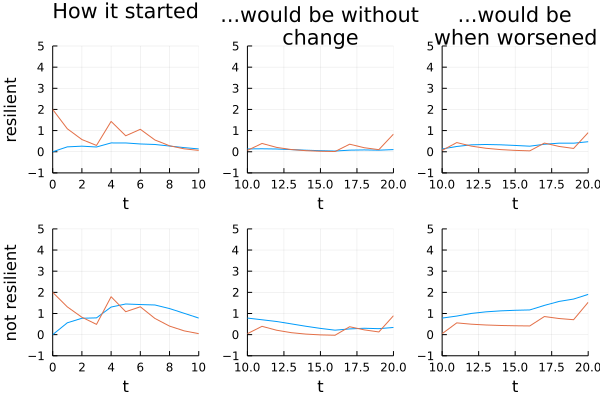

In [6]:
plot_siumlation(r0p1, r0p2, r0p2_worse, r1p1, r1p2, r1p2_worse)

### Simulated data in the observed data space

This serves as inputs to the VAEs. 

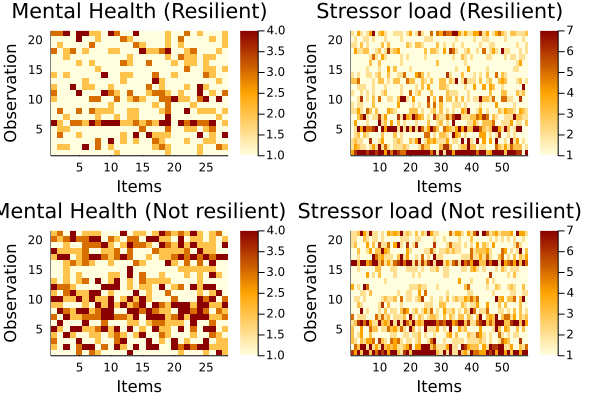

In [7]:
mentalh_heatmap_res = Plots.heatmap(simdata[findlast(x -> x==0, rtype)].data.Xmh, title = "Mental Health (Resilient)", ylabel = "Observation", xlabel = "Items", clim = (1, 4), c = :heat);
stressors_heatmap_res = Plots.heatmap(simdata[findlast(x -> x==0, rtype)].data.Xsl, title = "Stressor load (Resilient)", ylabel = "Observation", xlabel = "Items", clim = (1, 7), c = :heat);

mentalh_heatmap_nonres = Plots.heatmap(simdata[findlast(x -> x==1, rtype)].data.Xmh, title = "Mental Health (Not resilient)", ylabel = "Observation", xlabel = "Items", clim = (1, 4), c = :heat);
stressors_heatmap_nonres = Plots.heatmap(simdata[findlast(x -> x==1, rtype)].data.Xsl, title = "Stressor load (Not resilient)", ylabel = "Observation", xlabel = "Items", clim = (1, 7), c = :heat);
display(Plots.plot(mentalh_heatmap_res, stressors_heatmap_res, mentalh_heatmap_nonres, stressors_heatmap_nonres, layout = @layout [a b ; c d]))

# Training

Next, we will train the two components of our model, i.e., the Variational AutoEncoders and the ODEnet with sub-periods.

## Variational AutoEncoders

We will start with the two Variational AutoEncoders (VAEs; see `moduleVAE.jl` for the code). To train the VAEs, we will extract the individual observations into a joint matrix.

In [8]:
Xmh = Matrix{Float32}(reduce(vcat, simdata[i].data.Xmh for i in 1:size(simdata,1)))';
Xsl = Matrix{Float32}(reduce(vcat, simdata[i].data.Xsl for i in 1:size(simdata,1)))';

trainedEncoder_mh, trainedDecoder_mh = train_vae(Xmh, epochs = 140, seed = 6, η = 0.00084999, save_model = false, verbose_freq = 20);
trainedEncoder_sl, trainedDecoder_sl = train_vae(Xsl, epochs = 140, seed = 6, η = 0.00084999, input_dim=58, save_model = false, verbose_freq = 20);

┌ Info: Start Training, total 140 epochs with η=0.00084999 and batch size 32
└ @ Main.moduleVAE /Users/goekoe/Workspace/iddm/src/moduleVAE.jl:132
┌ Info: loss epoch 20/140: 93.22
└ @ Main.moduleVAE /Users/goekoe/Workspace/iddm/src/moduleVAE.jl:147


┌ Info: loss epoch 40/140: 15.14
└ @ Main.moduleVAE /Users/goekoe/Workspace/iddm/src/moduleVAE.jl:147
┌ Info: loss epoch 60/140: 13.82
└ @ Main.moduleVAE /Users/goekoe/Workspace/iddm/src/moduleVAE.jl:147


┌ Info: loss epoch 80/140: 13.35
└ @ Main.moduleVAE /Users/goekoe/Workspace/iddm/src/moduleVAE.jl:147
┌ Info: loss epoch 100/140: 13.2
└ @ Main.moduleVAE /Users/goekoe/Workspace/iddm/src/moduleVAE.jl:147


┌ Info: loss epoch 120/140: 13.06
└ @ Main.moduleVAE /Users/goekoe/Workspace/iddm/src/moduleVAE.jl:147
┌ Info: loss epoch 140/140: 13.03
└ @ Main.moduleVAE /Users/goekoe/Workspace/iddm/src/moduleVAE.jl:147


┌ Info: Start Training, total 140 epochs with η=0.00084999 and batch size 32
└ @ Main.moduleVAE /Users/goekoe/Workspace/iddm/src/moduleVAE.jl:132
┌ Info: loss epoch 20/140: 211.57
└ @ Main.moduleVAE /Users/goekoe/Workspace/iddm/src/moduleVAE.jl:147


┌ Info: loss epoch 40/140: -2.54
└ @ Main.moduleVAE /Users/goekoe/Workspace/iddm/src/moduleVAE.jl:147
┌ Info: loss epoch 60/140: -14.65
└ @ Main.moduleVAE /Users/goekoe/Workspace/iddm/src/moduleVAE.jl:147


┌ Info: loss epoch 80/140: -19.38
└ @ Main.moduleVAE /Users/goekoe/Workspace/iddm/src/moduleVAE.jl:147
┌ Info: loss epoch 100/140: -20.97
└ @ Main.moduleVAE /Users/goekoe/Workspace/iddm/src/moduleVAE.jl:147


┌ Info: loss epoch 120/140: -21.34
└ @ Main.moduleVAE /Users/goekoe/Workspace/iddm/src/moduleVAE.jl:147
┌ Info: loss epoch 140/140: -21.57
└ @ Main.moduleVAE /Users/goekoe/Workspace/iddm/src/moduleVAE.jl:147


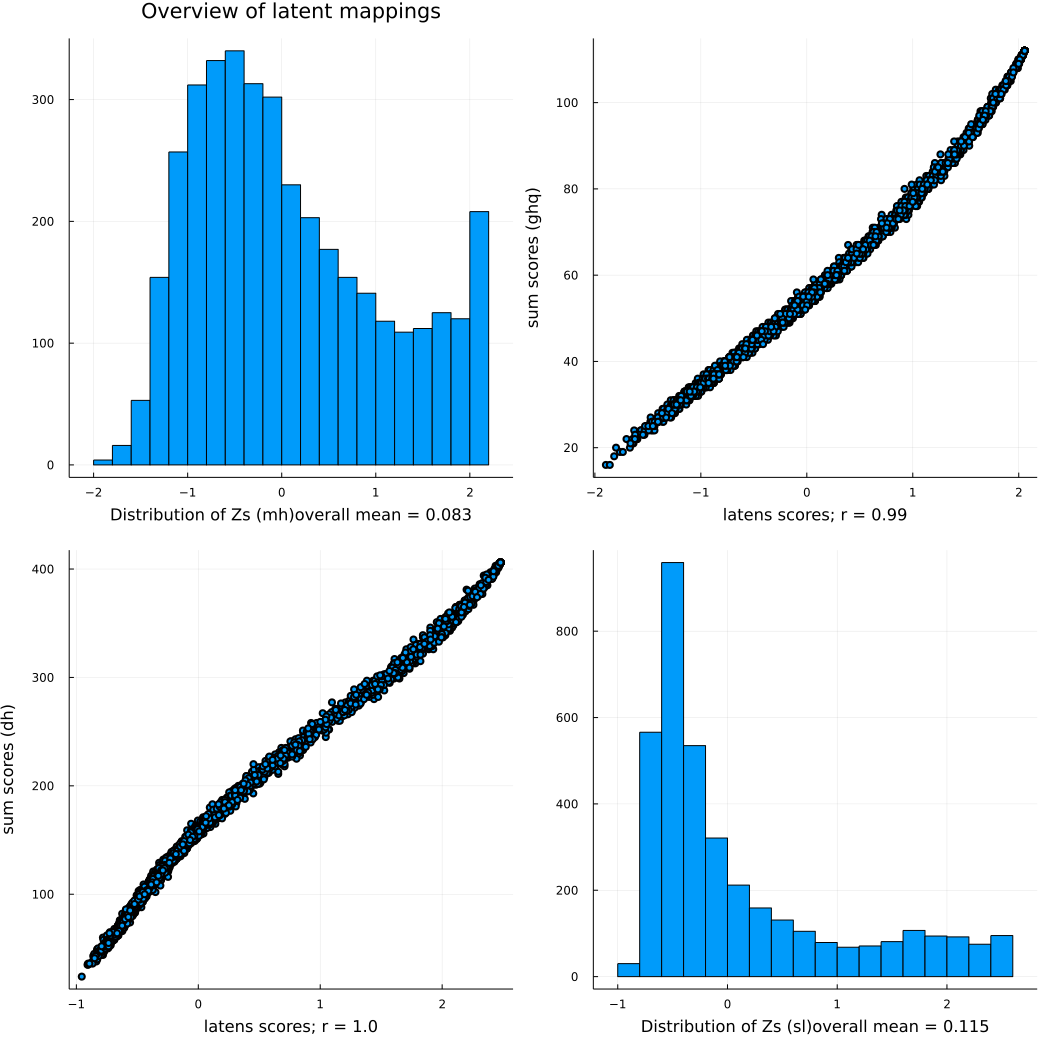

In [9]:
p = summary_plot_vae(Xmh, Xsl,  trainedEncoder_mh, trainedDecoder_mh, trainedEncoder_sl, trainedDecoder_sl, mytitle="Overview of latent mappings")

The plot above shows that the simulated structure of the observed items is obviously very simple. Therefore, a linear mapping would have been sufficient. Please note that the focus of this notebook is the ODEnet with the intra-individual sub-periods.

## ODEnet with sub-periods

The next step is to enrich the data struct `subject` with the mapping of the VAE to the latent space. A slot for this has been reserved in the mutual part of `subject`. While we showcase the mappings of the VAE, the lower dimensional representations of any other dimensionality reduction technique can be stored here and will be automatically accessed by the ODEnet.

In [10]:
for i in 1:n
    simdata[i].predVAE[1,:] = reconstruct(trainedEncoder_mh, trainedDecoder_mh, simdata[i].data.Xmh', cpu; my_seed=123)[1]
    simdata[i].predVAE[2,:] = reconstruct(trainedEncoder_sl, trainedDecoder_sl, simdata[i].data.Xsl', cpu; my_seed=123)[1]
end

The `update_stressor_level!()` function kicks the integrator to the actually observed value for each realized measure of stressor load. This functionality is provided by `DifferentialEquations.jl` (see [here](https://diffeq.sciml.ai/stable/tutorials/jump_diffusion/) and [here](https://diffeq.sciml.ai/stable/features/callback_functions/#Using-Callbacks) for an explanation). Please note, it is provided to the `base_prob` below which is then solved.

In [11]:
function update_stressor_level!(integrator)
    if W[2,:][findfirst(arg -> arg == integrator.t, t)] == 1.0 
        integrator.u[2] = z_sl[findfirst(arg -> arg == integrator.t, t)]
    end
end

update_stressor_level! (generic function with 1 method)

The definition of the `base_problem` is an important step, especially regarding the callback. In the next step, the `base_problem` is provided to the `train_node_sp()` function where is it used to `remake()` the `base_problem` for every individual (in every iteration). 

In [12]:
base_prob = ODEProblem(mydiff,
                                nothing, # initial conditions
                                (0.0, 20.0), # tspan
                                nothing, # initial parameters
                                callback = PresetTimeCallback(t, update_stressor_level!, save_positions=(false,false)));

Now, we can train the ODEnet with subperiods.

In [13]:
predictions, ODEnet, losses_per_training = train_node_sp(simdata, base_prob, collect(1:n); seed = 25, epochs =  250, hidden_dim = 14, η=5.3601e-5 , λ_sp=0.004, λ_ODEnet=0.0275515, λ_ODEp=0.00224545);

┌ Info: new ODEnet initialized
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:370
┌ Info: Start Training, total 250 epochs with η=5.3601e-5,  4 ODE parameters, and seed 25
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:283


┌ Info: train: 1.353; test: 0.742; epoch 10/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343
┌ Info: train: 1.252; test: 0.698; epoch 20/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343


┌ Info: train: 1.193; test: 0.682; epoch 30/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343
┌ Info: train: 1.152; test: 0.674; epoch 40/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343


┌ Info: train: 1.119; test: 0.669; epoch 50/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343
┌ Info: train: 1.092; test: 0.666; epoch 60/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343


┌ Info: train: 1.068; test: 0.665; epoch 70/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343
┌ Info: train: 1.047; test: 0.665; epoch 80/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343


┌ Info: train: 1.026; test: 0.664; epoch 90/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343
┌ Info: train: 1.007; test: 0.664; epoch 100/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343


┌ Info: train: 0.988; test: 0.662; epoch 110/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343
┌ Info: train: 0.971; test: 0.66; epoch 120/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343


┌ Info: train: 0.955; test: 0.657; epoch 130/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343
┌ Info: train: 0.94; test: 0.653; epoch 140/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343


┌ Info: train: 0.924; test: 0.651; epoch 150/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343
┌ Info: train: 0.91; test: 0.649; epoch 160/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343


┌ Info: train: 0.896; test: 0.647; epoch 170/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343
┌ Info: train: 0.884; test: 0.645; epoch 180/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343


┌ Info: train: 0.873; test: 0.641; epoch 190/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343
┌ Info: train: 0.864; test: 0.636; epoch 200/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343


┌ Info: train: 0.856; test: 0.629; epoch 210/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343
┌ Info: train: 0.849; test: 0.621; epoch 220/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343


┌ Info: train: 0.844; test: 0.615; epoch 230/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343
┌ Info: train: 0.84; test: 0.608; epoch 240/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343


┌ Info: train: 0.836; test: 0.602; epoch 250/250
└ @ Main.moduleODEnet_sp /Users/goekoe/Workspace/iddm/src/moduleODEnet_sp.jl:343


The `train_node_sp()` function provides the trained ODEnet as well as a new `vector{structs}`, i.e., the individual data now enriched with the smoothed mappings of the ODEnet. In case you want to have a look at all parameters of the ODEnet, the `extract_parameters()` function is provided. 

Please note, there is extensive monitoring of different loss components implemented already. It is switched off by default, you can switch it on with  `train_node_sp(simdata, base_prob, collect(1:n); tblogger = true)`

## Learning what has been learned

First, we will investigate whether the ODEnet has successfully distinguished the changing parameters. To do so, the plot below shows the four ODE parameters depending on the sub-period and change type. 

We see that the most right boxplot, showing the ODE parameters of those individuals with change in the second sub-period. The parameters $\beta$ and $\delta$ in particular are shifted upwards which reflects the worsening we simulated.

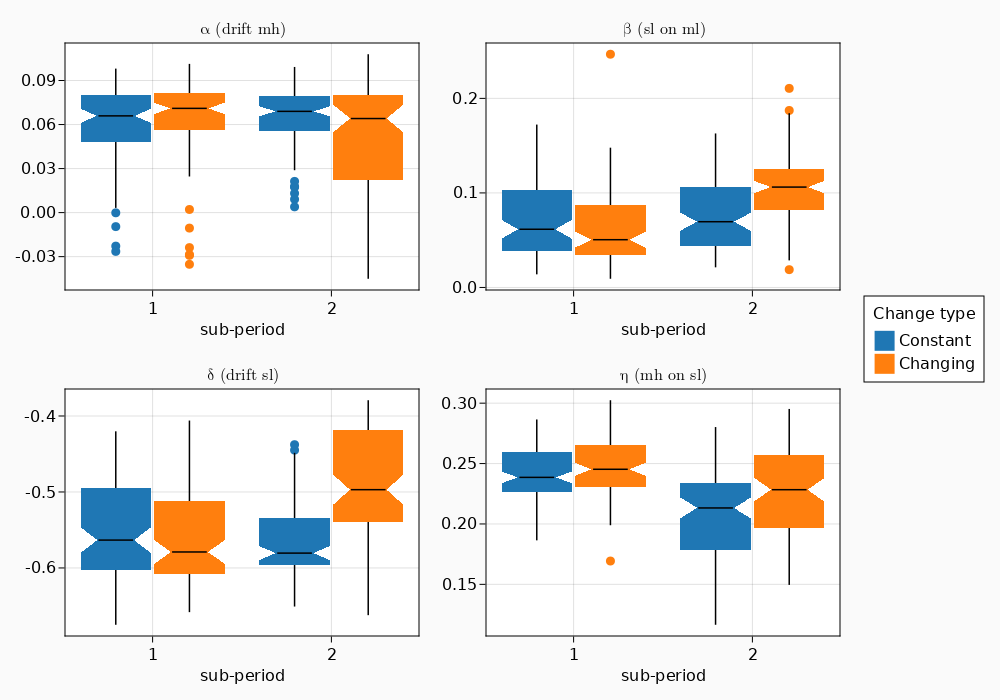

In [14]:
parameter_df_long = extract_parameters(simdata, ODEnet)
plot_ode_params(parameter_df_long, [:drift_ghq, :dh_on_ghq, :drift_dh, :ghq_on_dh], 
    :p, :ptype
)

Finally, we will have a look at an exemplary fit in the latent space.

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:20.
└ @ Plots /Users/goekoe/.julia/packages/Plots/1KWPG/src/utils.jl:132
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:20.
└ @ Plots /Users/goekoe/.julia/packages/Plots/1KWPG/src/utils.jl:132
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:20.
└ @ Plots /Users/goekoe/.julia/packages/Plots/1KWPG/src/utils.jl:132
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:20.
└ @ Plots /Users/goekoe/.julia/packages/Plots/1KWPG/src/utils.jl:132
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:20.
└ @ Plots /Users/goekoe/.julia/packages/Plots/1KWPG/src/utils.jl:132
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:20.
└ @ Plots /Users/goekoe/.julia/packages/Plots/1KWPG/src/utils.jl:132
┌ Warning: Indices Base.OneT

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:20.
└ @ Plots /Users/goekoe/.julia/packages/Plots/1KWPG/src/utils.jl:132
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:20.
└ @ Plots /Users/goekoe/.julia/packages/Plots/1KWPG/src/utils.jl:132
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:20.
└ @ Plots /Users/goekoe/.julia/packages/Plots/1KWPG/src/utils.jl:132
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:20.
└ @ Plots /Users/goekoe/.julia/packages/Plots/1KWPG/src/utils.jl:132


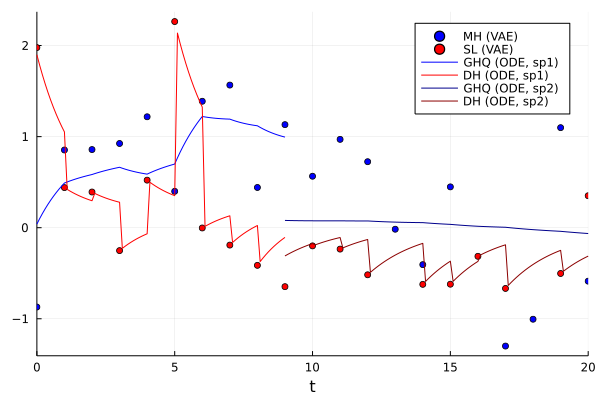

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:19.
└ @ Plots /Users/goekoe/.julia/packages/Plots/1KWPG/src/utils.jl:132
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:19.
└ @ Plots /Users/goekoe/.julia/packages/Plots/1KWPG/src/utils.jl:132
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:19.
└ @ Plots /Users/goekoe/.julia/packages/Plots/1KWPG/src/utils.jl:132
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:19.
└ @ Plots /Users/goekoe/.julia/packages/Plots/1KWPG/src/utils.jl:132
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:20.
└ @ Plots /Users/goekoe/.julia/packages/Plots/1KWPG/src/utils.jl:132
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:20.
└ @ Plots /Users/goekoe/.julia/packages/Plots/1KWPG/src/utils.jl:132
┌ Warning: Indices Base.OneT

In [15]:
import .moduleODEnet.update_stressor_level!
import .moduleODEnet_sp.calc_sp_solutions

# it might work to import it to crucial functions in case you dont want to go to the global env every time.
function update_stressor_level!(integrator)
    if W[2,:][findfirst(arg -> arg == integrator.t, t)] == 1.0 
        integrator.u[2] = z_sl[findfirst(arg -> arg == integrator.t, t)]
    end
end

current_subject=1
base_prob = ODEProblem(mydiff,nothing, # u0
                                (0.0, 20.0), # tspan
                                nothing, # initial parameters
                                callback = PresetTimeCallback(t, update_stressor_level!, save_positions=(false,false)));

plot_exemplary_subject(ODEnet, simdata, 12)